In [2]:
import os, sys                       # OS stands for Operating System and provides ways for python to interact with files or directories
from collections import Counter  # Collections is a package for handling data
from pprint import pprint

import pandas as pd              # Pandas is a data analysis library which we'll primarily use to handle our dataset
import numpy as np               # Numpy is a package for scientific computing. We'll use it for some of it's math functions

import matplotlib                # Matplotlib is the plotting package that we'll use throughout the lab
import matplotlib.pyplot as plt
import seaborn as sns            # Seaborn is a Python data visualization library based on matplotlib


from sklearn.preprocessing import MinMaxScaler # Scikit-learn is a machine learning package, providing the backbone for the work we'll perform
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn import metrics
from sklearn.model_selection import cross_validate, GridSearchCV, ParameterGrid
from sklearn.model_selection import KFold, RepeatedKFold

from xgboost import XGBClassifier # Extreme gradient boosting based on decision trees
import xgboost as xgb

seed = 12345

In [3]:
# load the data
parkinsons_original = pd.read_csv('parkinsonsdata.csv')
parkinsons_original.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


Feature Engineering

Remove constant columns, get the features and labels,and normalize them.

In [4]:
# remove column name
parkinsons_df = parkinsons_original.drop("name", axis = 1)

# get the features and lables by splitting into two dataframes
features = parkinsons_df.loc[:,parkinsons_df.columns!='status'].values[:,1:]
labels = parkinsons_df.loc[:,'status'].values

# remove constant columns
parkinsons_df_noconstant = parkinsons_df.loc[:, (parkinsons_df != parkinsons_df.iloc[0]).any()]

# remove highly correlated features
parkinsons_nocorr_df = parkinsons_df_noconstant.corr(method = "pearson").abs()

# filter the features with correlation coefficients above 0.95
upper = parkinsons_nocorr_df.where(np.triu(np.ones(parkinsons_nocorr_df.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
parkinsons_df_lowcorr = parkinsons_df_noconstant.drop(columns=to_drop)
# recalculate the correlation matrix so we can compare
parkinsons_corr_df_update = parkinsons_df_lowcorr.corr(method="pearson").abs()

# count of label 0 and 1 -> (147 label 1, 48 label 0)
print(labels[labels==1].shape[0], labels[labels==0].shape[0])
# number of columns
len(parkinsons_df_noconstant.columns)

147 48


23

In [5]:
# normalize the features
# initialise MinMaxScaler with scaling range of -1 to 1.
scale = MinMaxScaler((-1,1))
x = scale.fit_transform(features)
y = labels

Set up for Model Evaluation 

X_train: training set input data
X_test: test set input data
y_train: training set output data
y_test: test set output data

In [6]:
# generate train/test split by keeping 20% of data as test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 7)

C:\Users\kinja\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kinja\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


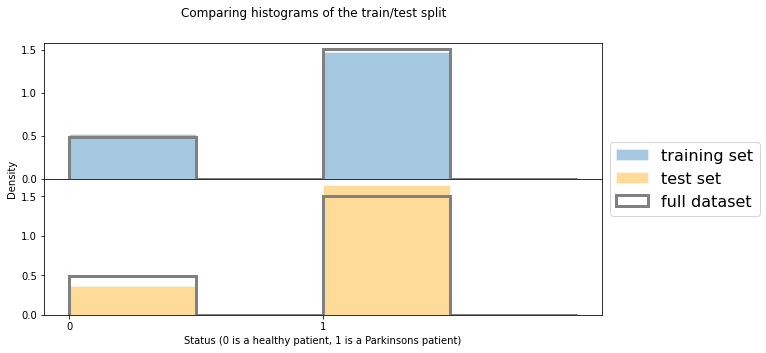

In [7]:
# evaluate train/test split using histogram
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,5), sharex = True, gridspec_kw={'hspace': 0})
fig.set_tight_layout(False)
myarray = parkinsons_original["status"]

bins = np.true_divide(range(5),2)

l1 = sns.distplot(y_train.astype("float"), hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"edgecolor": "white"}, label = 'training set', ax = ax1)
l2 = sns.distplot(y_test.astype("float"), hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"edgecolor": "white", "color": "orange"}, label = 'test set', ax = ax2)
l3 = sns.distplot(myarray, hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"histtype": "step","linewidth": 3, "alpha": 1, "color": "grey"}, ax = ax1)
l4 = sns.distplot(myarray, hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"histtype": "step","linewidth": 3, "alpha": 1, "color": "grey"}, label = 'full dataset', ax = ax2)


ax1.set_xticks(range(2))
ax2.set_xticks(range(2))
ax2.xaxis.label.set_visible(False)
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
fig.suptitle('Comparing histograms of the train/test split')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.legend(handles, labels, loc = 'center left', bbox_to_anchor=(1, 0.5),prop={'size': 16})
plt.xlabel('Status (0 is a healthy patient, 1 is a Parkinsons patient)')
_ = plt.ylabel('Density')

Fitting and evaluating a default model

In [8]:
# initialise the XGBCLassifier and train the model on training data
model = XGBClassifier()
model.fit(x_train, y_train)

print('Model Training Complete')

C:\Users\kinja\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Training Complete


In [9]:
# generate predictions for training and testing data
train_predict = model.predict(x_train)  # training data
test_predict = model.predict(x_test)    # testing data

# parity_plots_side_by_side(y_train,train_predict,y_test,test_predict,title_left="Training Data Parity Plot",title_right="Test Data Parity Plot") # build both plots
# parity_stats_side_by_side(y_train,train_predict,y_test,test_predict,"Training Data","Test Data")  # print error metrics for training data

In [10]:
# calculate the accuracy of the model 
print(accuracy_score(y_test, test_predict) *100)

92.3076923076923


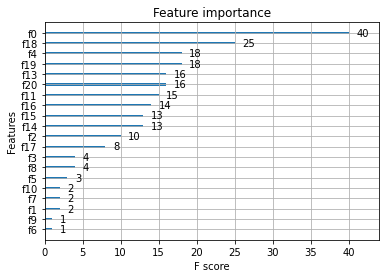

In [17]:
# feature importance
xgb.plot_importance(model)
#plt.figure(figsize=(50,50))
plt.show()

Generate ROC curve and AUC

Random: ROC AUC=0.500
Model: ROC AUC=0.987


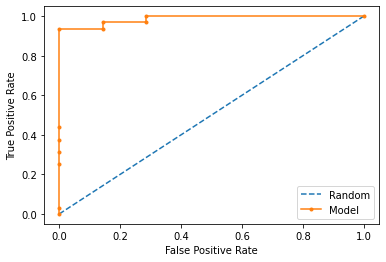

In [12]:
# generate a no skill prediction (majority class)
random_probs = [0 for _ in range(len(y_test))]
# predict probabilities
model_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
model_probs = model_probs[:, 1]
# calculate scores
random_auc = metrics.roc_auc_score(y_test, random_probs)
model_auc = metrics.roc_auc_score(y_test, model_probs)
# summarize scores
print('Random: ROC AUC=%.3f' % (random_auc))
print('Model: ROC AUC=%.3f' % (model_auc))
# calculate roc curves
random_fpr, random_tpr, _ = metrics.roc_curve(y_test, random_probs)
model_fpr, model_tpr, _ = metrics.roc_curve(y_test, model_probs)
# plot the roc curve for the model
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
plt.plot(model_fpr, model_tpr, marker='.', label='Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Improving the Model by Optimizing Hyperparameters

In [13]:
# get the default parameters used
print('Default model uses the following hyperparameters: \n')
pprint(model.get_params())

Default model uses the following hyperparameters: 

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'use_label_encoder': True,
 'validate_parameters': 1,
 'verbosity': None}


In [14]:
# build DMatrices to use the native API for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# default parameters to tune
params = {'max_depth':6,'min_child_weight':1}
kfold = 5
num_boost_round = 999
default_auc = 0.987

In [15]:
# tuning max_depth and min_child_weight
    # to find a good trade-off between model bias and variance
gridsearch_params = [(max_depth, min_child_weight) for max_depth in range(9,12) for min_child_weight in range(5,8)]

# running a cross validation on each of above pairs
best_max_depth = 6
best_min_child_weight = 1
best_accuracy = 0.923

for max_depth, min_child_weight in gridsearch_params:
    print('CV with max_depth={}, min_child_weight={}'.format(
                             max_depth,
                             min_child_weight))
    # update the params
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # run cv
    cv_results = xgb.cv(
        params, dtrain, nfold=kfold, metrics={'auc'}, early_stopping_rounds=10,seed=seed, num_boost_round=num_boost_round
    )

    # update best auc
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))

    if mean_auc > default_auc:
        default_auc = mean_auc
        best_params = (max_depth,min_child_weight)
    
    print("Best max depth: {}, Best min child depth: {}, AUC: {}".format(best_max_depth, best_min_child_weight, default_auc))

    


CV with max_depth=9, min_child_weight=5
	AUC 0.9268254 for 0 rounds
Best max depth: 6, Best min child depth: 1, AUC: 0.987
CV with max_depth=9, min_child_weight=6
	AUC 0.9520818 for 0 rounds
Best max depth: 6, Best min child depth: 1, AUC: 0.987
CV with max_depth=9, min_child_weight=7
	AUC 0.9433447999999999 for 0 rounds
Best max depth: 6, Best min child depth: 1, AUC: 0.987
CV with max_depth=10, min_child_weight=5
	AUC 0.9277344 for 0 rounds
Best max depth: 6, Best min child depth: 1, AUC: 0.987
CV with max_depth=10, min_child_weight=6
	AUC 0.952506 for 0 rounds
Best max depth: 6, Best min child depth: 1, AUC: 0.987
CV with max_depth=10, min_child_weight=7
	AUC 0.9492571999999999 for 0 rounds
Best max depth: 6, Best min child depth: 1, AUC: 0.987
CV with max_depth=11, min_child_weight=5
	AUC 0.9286436 for 0 rounds
Best max depth: 6, Best min child depth: 1, AUC: 0.987
CV with max_depth=11, min_child_weight=6
	AUC 0.9534151999999999 for 0 rounds
Best max depth: 6, Best min child depth:

In [ ]:
# set up hyperparamater grid
    # a dictionary of hyperparametere candidates that we want the optimization strategy to consider
#learning_rate = [0.1,0.2,0.3,0.4]   default - 0.300000012
#n_estimators = [50, 80, 1000, 1500]  default - 100
#max_depth = [4, 6, 8, 10]            default - 6
#                                    default model accuracy - 0.923
#opt_dict1 = {'learning_rate':0.1,'n_estimators':n_estimators,'max_depth':5}


In [40]:
# function to create XGBoost Models and perform cross-validation
#def modelfit():
#    print('Running Cross Validation')
#    opt_model = XGBClassifier()
    